# Anomaly Detection UI Dashboard

This notebook serves as a user interface for running anomaly detection experiments using the lib/ modules.

## Overview

The notebook provides an interactive interface to:
- Load and preprocess Tennessee Eastman Process data
- Configure and run anomaly detection experiments
- Visualize results and compare model performance
- Generate comprehensive analysis reports

In [30]:
# Import the anomaly detection library and reload modules
import importlib
import sys

# Remove any cached modules to ensure we get the latest version
modules_to_reload = [module for module in sys.modules.keys() if module.startswith('lib')]
for module in modules_to_reload:
    if module in sys.modules:
        del sys.modules[module]

# Clear import cache
importlib.invalidate_caches()

# Import the library
import lib

# Display configuration
lib.print_configuration()

ANOMALY DETECTION LIBRARY CONFIGURATION
Fault injection point: 160
Default simulation runs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Default fault numbers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Model configurations:
  MCUSUM: {'default_k': 0.5, 'default_h': None, 'delta_magnitude': 0.1}
  Autoencoder: {'encoding_dim': 8, 'epochs': 50, 'batch_size': 32, 'threshold_percentile': 95}
  EWMA: {'lambda_': 0.2, 'percentile': 99.5}

Available detectors: ['MCUSUM', 'Autoencoder', 'AutoencoderEnhanced', 'MEWMA', 'MEWMS', 'MEWMV', 'REWMV', 'MaxMEWMV', 'MNSE']
Minimal detectors: ['MCUSUM', 'AutoencoderEnhanced', 'MEWMA', 'MEWMS']


In [44]:
# In case of further edits, reload the module and print configuration again
importlib.reload(lib)
lib.print_configuration()

ANOMALY DETECTION LIBRARY CONFIGURATION
Fault injection point: 160
Default simulation runs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Default fault numbers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Model configurations:
  MCUSUM: {'default_k': 0.5, 'default_h': None, 'delta_magnitude': 0.1}
  Autoencoder: {'encoding_dim': 8, 'epochs': 50, 'batch_size': 32, 'threshold_percentile': 95}
  EWMA: {'lambda_': 0.2, 'percentile': 99.5}

Available detectors: ['MCUSUM', 'Autoencoder', 'AutoencoderEnhanced', 'MEWMA', 'MEWMS', 'MEWMV', 'REWMV', 'MaxMEWMV', 'MNSE']
Minimal detectors: ['MCUSUM', 'AutoencoderEnhanced', 'MEWMA', 'MEWMS']


## Step 1: Experiment Configuration

**⚠️ IMPORTANT: Configure your experiment parameters FIRST!**

Set your fault numbers, simulation runs, and detector settings here BEFORE loading data.

In [12]:
# Configure experiment FIRST before loading any data
config = lib.ExperimentConfig(
    simulation_runs=range(1, 6),  # ← FIXED: was range(1,1) which is EMPTY!
    fault_numbers=range(1, 2),    # ← CHANGE THIS to set which faults to analyze
    use_minimal_registry=True,    # Use minimal set of detectors
    verbose=True
)

print("Experiment configuration set:")
print(f"  Simulation runs: {list(config.simulation_runs)}")
print(f"  Fault numbers: {list(config.fault_numbers)}")
print(f"  Use minimal registry: {config.use_minimal_registry}")
print(f"  Verbose output: {config.verbose}")
print("\nConfiguration completed! You can now proceed to load data.")

# ⚠️ CRITICAL FIX: simulation_runs was EMPTY due to range(1,1)!

Experiment configuration set:
  Simulation runs: [1, 2, 3, 4, 5]
  Fault numbers: [1]
  Use minimal registry: True
  Verbose output: True

Configuration completed! You can now proceed to load data.


## Step 2: Data Loading and Preprocessing

Now load the data using the configuration above.

In [13]:
# Load Tennessee Eastman Process data
print("Loading TEP data...")
# Specify the correct path to the data directory
df_ff_training, df_ff_testing, df_f_training, df_f_testing = lib.load_tep_data("../data")

print(f"Fault-free training data shape: {df_ff_training.shape}")
print(f"Fault-free testing data shape: {df_ff_testing.shape}")
print(f"Faulty training data shape: {df_f_training.shape}")
print(f"Faulty testing data shape: {df_f_testing.shape}")

# Prepare full in-control training data for model initialization
from lib.data.preprocessing import prepare_full_incontrol_data
X_incontrol_train_full, scaler_full = prepare_full_incontrol_data(df_ff_training)

print(f"Full in-control training data shape: {X_incontrol_train_full.shape}")
print("Data loading completed successfully!")
print("✅ Data is now ready to use with your configuration above!")

Loading TEP data...
Fault-free training data shape: (250000, 55)
Fault-free testing data shape: (480000, 55)
Faulty training data shape: (5000000, 55)
Faulty testing data shape: (9600000, 55)
Full in-control training data shape: (250000, 52)
Data loading completed successfully!
✅ Data is now ready to use with your configuration above!
Fault-free training data shape: (250000, 55)
Fault-free testing data shape: (480000, 55)
Faulty training data shape: (5000000, 55)
Faulty testing data shape: (9600000, 55)
Full in-control training data shape: (250000, 52)
Data loading completed successfully!
✅ Data is now ready to use with your configuration above!


In [ ]:
# 🔧 FILTER DATA TO MATCH YOUR CONFIGURATION
print("? FILTERING DATA TO MATCH YOUR CONFIGURATION:")
print(f"   Original faulty training data: {df_f_training.shape}")
print(f"   Original faulty testing data: {df_f_testing.shape}")

# Filter training data to only include configured faults
df_f_training_filtered = df_f_training[df_f_training['faultNumber'].isin(config.fault_numbers)].copy()
df_f_testing_filtered = df_f_testing[df_f_testing['faultNumber'].isin(config.fault_numbers)].copy()

print(f"\n✅ FILTERED TO YOUR CONFIGURATION:")
print(f"   Configured faults: {list(config.fault_numbers)}")
print(f"   Filtered faulty training data: {df_f_training_filtered.shape}")
print(f"   Filtered faulty testing data: {df_f_testing_filtered.shape}")

# Update the global variables to use filtered data
df_f_training = df_f_training_filtered
df_f_testing = df_f_testing_filtered

# Verify the filtering worked
unique_faults_after = sorted(df_f_training['faultNumber'].unique())
print(f"\n📊 VERIFICATION - FAULTS IN FILTERED DATA:")
print(f"   Distinct faults: {unique_faults_after}")
print(f"   Count: {len(unique_faults_after)} faults")

# Count samples per fault in filtered data
fault_counts = df_f_training['faultNumber'].value_counts().sort_index()
print(f"\n📈 SAMPLES PER CONFIGURED FAULT:")
for fault, count in fault_counts.items():
    print(f"   Fault {fault}: {count:,} samples")

print(f"\n✅ SUCCESS: Data now contains only your configured faults!")

In [19]:
# ✅ QUICK CONFIGURATION vs DATA CHECK
print("🔍 CONFIGURATION vs DATA SUMMARY")
print("=" * 50)

print("📋 YOUR CONFIGURATION:")
print(f"   Simulation runs: {list(config.simulation_runs)} (count: {len(config.simulation_runs)})")
print(f"   Fault numbers: {list(config.fault_numbers)} (count: {len(config.fault_numbers)})")

print(f"\n📁 ACTUAL DATA AVAILABLE:")
try:
    available_faults = sorted(df_f_testing['faultNumber'].unique())
    available_sims = sorted(df_f_testing['simulationRun'].unique()) 
    
    print(f"   Available faults: {len(available_faults)} total")
    print(f"   Range: {min(available_faults)} to {max(available_faults)}")
    print(f"   First 10: {available_faults[:10]}")
    if len(available_faults) > 10:
        print(f"   ... and {len(available_faults)-10} more")
    
    print(f"\n   Available simulations: {len(available_sims)} total") 
    print(f"   Range: {min(available_sims)} to {max(available_sims)}")
    print(f"   First 10: {available_sims[:10]}")
    if len(available_sims) > 10:
        print(f"   ... and {len(available_sims)-10} more")
        
    print(f"\n🎯 EXPERIMENT SCOPE:")
    total_config = len(config.simulation_runs) * len(config.fault_numbers)
    total_available = len(available_sims) * len(available_faults)
    print(f"   Your config would run: {total_config} combinations")
    print(f"   Data has available: {total_available} combinations")
    
    if total_config > 100:
        print(f"   ⚠️ WARNING: {total_config} is a LOT of experiments!")
        print(f"   Consider reducing fault_numbers or simulation_runs for testing")
    
except Exception as e:
    print(f"   ❌ Error checking data: {e}")

print(f"\n✅ Quick check completed!")
print("=" * 50)

🔍 CONFIGURATION vs DATA SUMMARY
📋 YOUR CONFIGURATION:
   Simulation runs: [1, 2, 3, 4, 5] (count: 5)
   Fault numbers: [1] (count: 1)

📁 ACTUAL DATA AVAILABLE:
   Available faults: 20 total
   Range: 1 to 20
   First 10: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10)]
   ... and 10 more

   Available simulations: 500 total
   Range: 1.0 to 500.0
   First 10: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0)]
   ... and 490 more

🎯 EXPERIMENT SCOPE:
   Your config would run: 5 combinations
   Data has available: 10000 combinations

✅ Quick check completed!


## Step 3: Model Initialization

Initialize all anomaly detection models with the training data using the configuration from Step 1.

In [ ]:
# Initialize models and create detector registry using the config from Step 1
print("Initializing models...")
print(f"Using configuration: {len(config.fault_numbers)} faults, {len(config.simulation_runs)} simulation runs")

model_instances, detector_registry = lib.setup_experiment(X_incontrol_train_full, config)

print(f"\nAvailable detectors: {list(detector_registry.keys())}")
print("Model initialization completed!")

Initializing models...
control limit h: None
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 2s 233us/step
7813/7813 ━━━━━━━━━━━━━━━━━━━━ 2s 233us/step
Initialized 9 models
Created detector registry with 4 detectors:
  - MCUSUM
  - AutoencoderEnhanced
  - MEWMA
  - MEWMS

Available detectors: ['MCUSUM', 'AutoencoderEnhanced', 'MEWMA', 'MEWMS']
Model initialization completed!
Initialized 9 models
Created detector registry with 4 detectors:
  - MCUSUM
  - AutoencoderEnhanced
  - MEWMA
  - MEWMS

Available detectors: ['MCUSUM', 'AutoencoderEnhanced', 'MEWMA', 'MEWMS']
Model initialization completed!


## Step 4: Quick Single Experiment

Let's run a quick experiment with specific simulation run and fault number to test the system.

In [34]:
# Prepare data for a single experiment
simulation_run = 1
fault_number = 2

print(f"Running experiment: Simulation {simulation_run}, Fault {fault_number}")

# Prepare experiment data
experiment_data = lib.prepare_experiment_data(
    df_ff_training, df_ff_testing, df_f_training, df_f_testing,
    simulation_run, fault_number, apply_fault_injection_cutoff=True
)

print(f"In-control test data shape: {experiment_data['X_incontrol_test'].shape}")
print(f"Faulty test data shape: {experiment_data['X_faulty_test'].shape}")

# Test each detector
from lib.evaluation.metrics import run_single_experiment

results = []
for detector_name, detector_func in detector_registry.items():
    result = run_single_experiment(
        detector_func,
        experiment_data['X_incontrol_test'],
        experiment_data['X_faulty_test'],
        detector_name
    )
    results.append(result)
    print(f"{detector_name}: ARL0={result['ARL0']}, ARL1={result['ARL1']}, Detection Rate={result['detection_fraction']:.3f}")

print("\nSingle experiment completed!")

Running experiment: Simulation 1, Fault 2
In-control test data shape: (800, 52)
Faulty test data shape: (800, 52)
MCUSUM: ARL0=3, ARL1=3, Detection Rate=0.996
AutoencoderEnhanced: ARL0=17, ARL1=6, Detection Rate=0.991
MEWMA: ARL0=66, ARL1=8, Detection Rate=0.990
MEWMS: ARL0=25, ARL1=8, Detection Rate=0.990

Single experiment completed!
MEWMS: ARL0=25, ARL1=8, Detection Rate=0.990

Single experiment completed!


## Step 4: MCUSUM Diagnostic Visualization

Let's create diagnostic plots for the MCUSUM detector to visualize its performance.

MCUSUM parameters: k=6.403, h=3.876


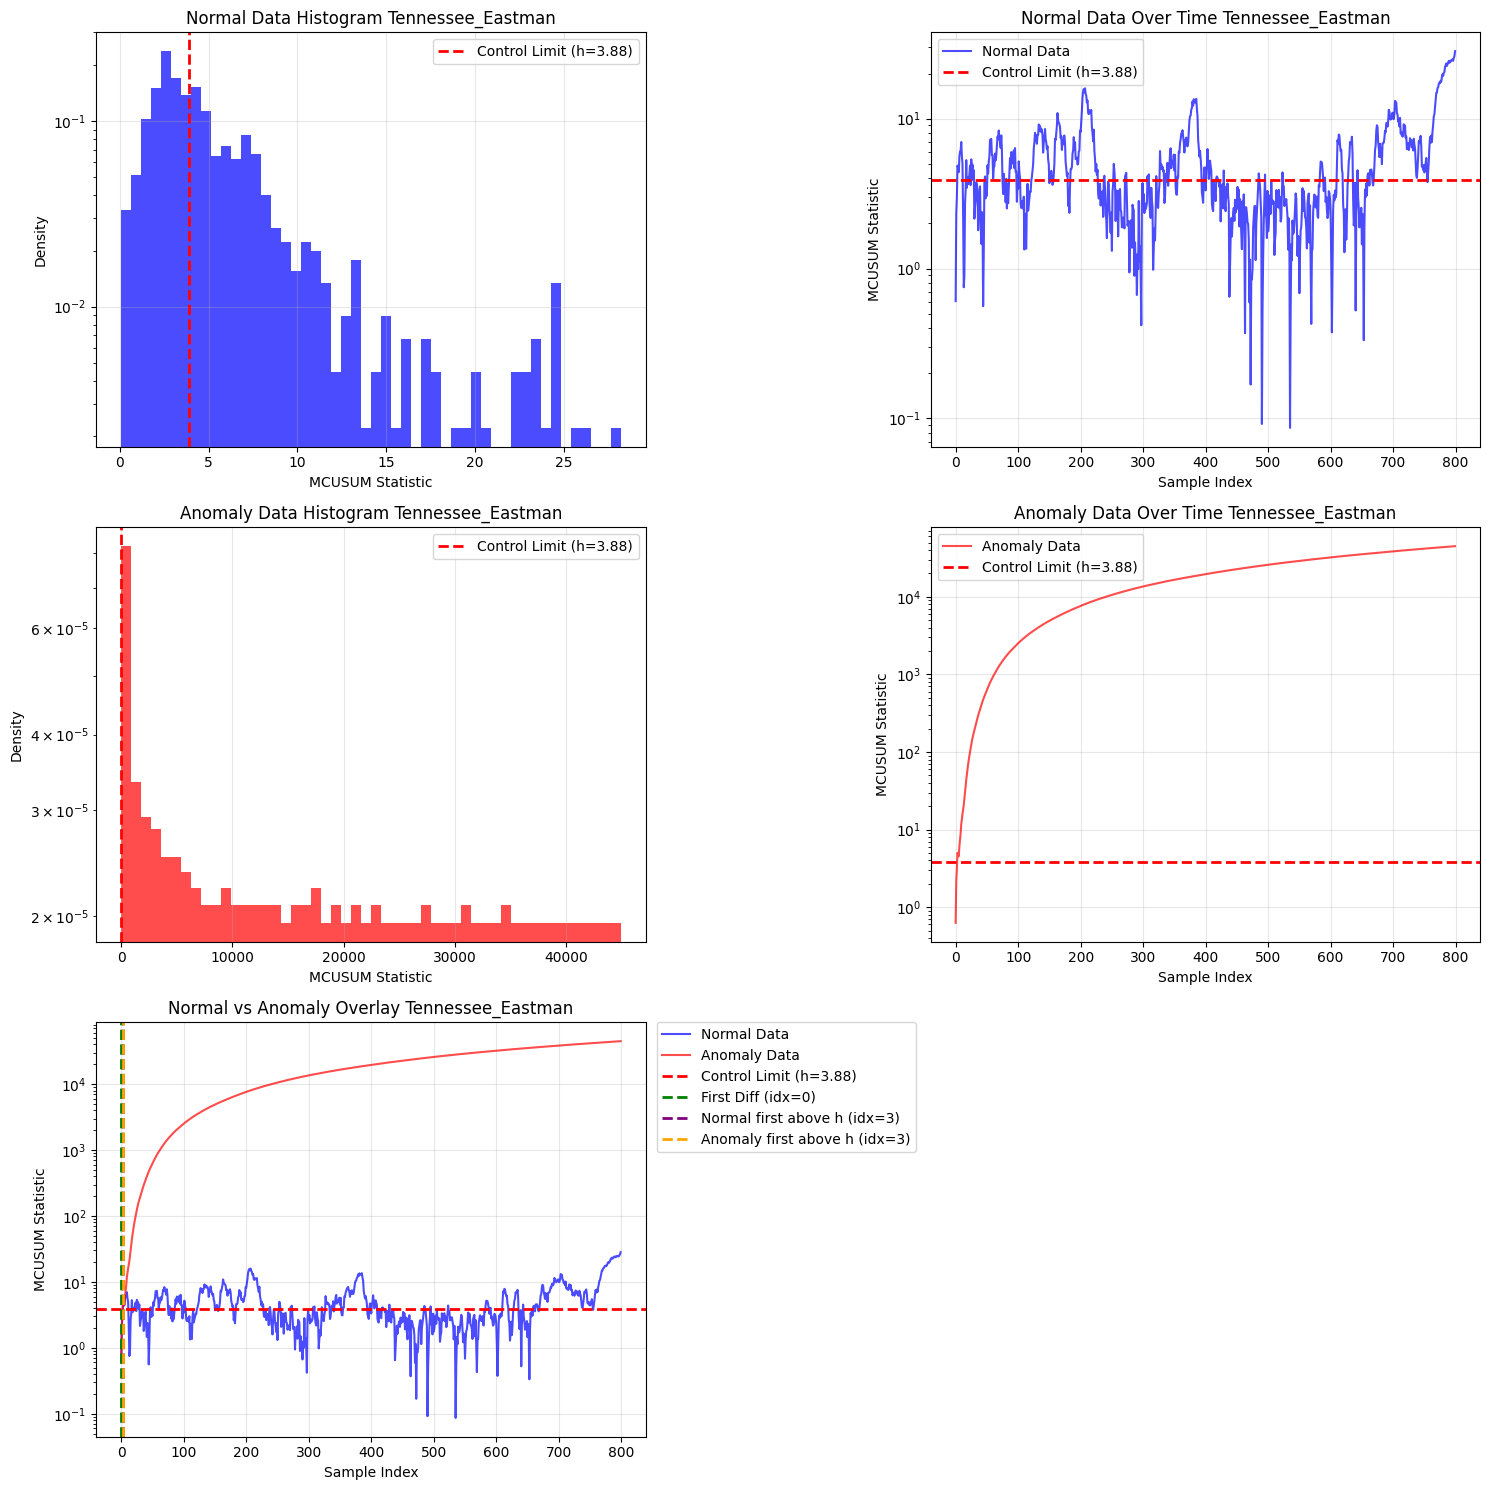

MCUSUM Results:
  False alarms in normal data: 414
  Detections in anomaly data: 797
  Detection rate: 0.996


In [35]:
# Get MCUSUM instance and create diagnostic plots
import numpy as np
from lib.config import get_model_instance
from lib.evaluation.metrics import apply_detector_with_mcusum_diagnostics

mcusum = get_model_instance('mcusum')

print(f"MCUSUM parameters: k={mcusum.k:.3f}, h={mcusum.h:.3f}")

# Apply MCUSUM with diagnostic plots
flags_normal, flags_anomaly = apply_detector_with_mcusum_diagnostics(
    mcusum,
    experiment_data['X_incontrol_test'],
    experiment_data['X_faulty_test'],
    verbose=True
)

print(f"MCUSUM Results:")
print(f"  False alarms in normal data: {np.sum(flags_normal)}")
print(f"  Detections in anomaly data: {np.sum(flags_anomaly)}")
print(f"  Detection rate: {np.mean(flags_anomaly):.3f}")

## Step 5: Time Series Visualization

Visualize the raw time series data to understand the fault injection pattern.

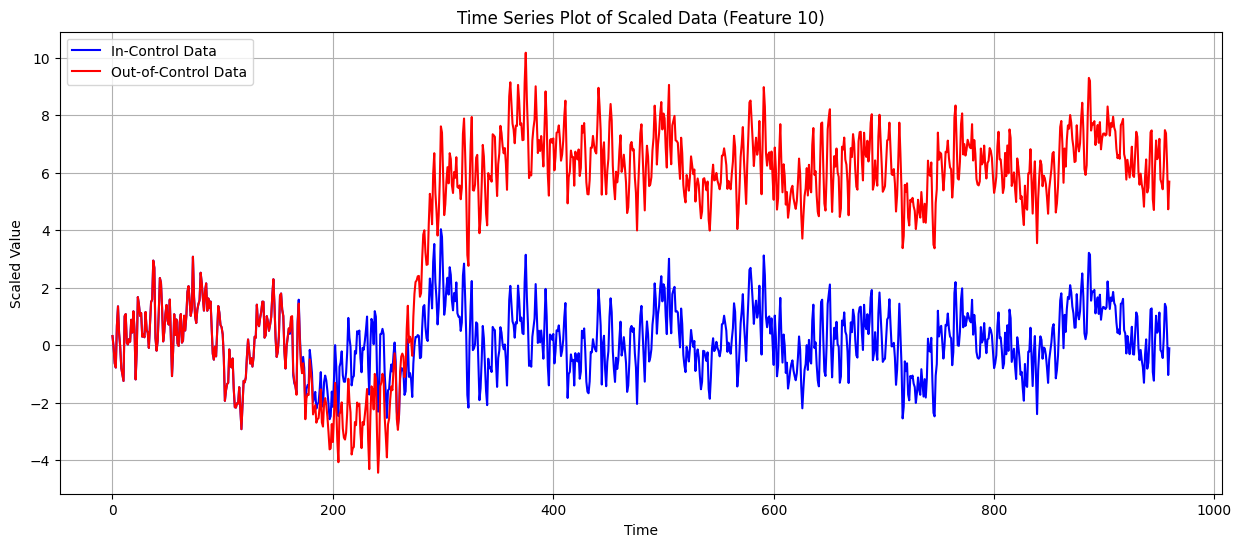

Time series plot shows feature 10 across time
Fault injection occurs around sample 160


In [36]:
# Plot time series for a specific feature
from lib.visualization.plots import plot_time_series_feature

# Get uncut data to show fault injection point
experiment_data_uncut = lib.prepare_experiment_data(
    df_ff_training, df_ff_testing, df_f_training, df_f_testing,
    simulation_run, fault_number, apply_fault_injection_cutoff=False
)

# Plot feature 10 (you can change this)
feature_idx = 10
plot_time_series_feature(
    experiment_data_uncut['X_incontrol_test'],
    experiment_data_uncut['X_faulty_test'],
    feature_idx=feature_idx,
    figsize=(15, 6)
)

print(f"Time series plot shows feature {feature_idx} across time")
print(f"Fault injection occurs around sample {lib.FAULT_INJECTION_POINT}")

## Step 6: Batch Experiments

Run batch experiments across multiple simulation runs and fault types.

In [37]:
# Prepare batch experiment data
print("Preparing batch experiment data...")
batch_data = lib.prepare_batch_experiment_data(
    df_ff_training, df_ff_testing, df_f_training, df_f_testing,
    config.simulation_runs, config.fault_numbers, 
    apply_fault_injection_cutoff=True
)

# Run batch experiments
print("Running batch experiments...")
print(f"This will test {len(config.simulation_runs)} simulation runs × {len(config.fault_numbers)} faults × {len(detector_registry)} detectors")
print(f"Total experiments: {len(config.simulation_runs) * len(config.fault_numbers) * len(detector_registry)}")

results = lib.run_batch_experiments(
    detector_registry, batch_data, 
    config.simulation_runs, config.fault_numbers, 
    verbose=True
)

print(f"\nBatch experiments completed! Generated {len(results)} results.")

Preparing batch experiment data...
Running batch experiments...Running batch experiments...
This will test 5 simulation runs × 5 faults × 4 detectors
Total experiments: 100
Processing simulation run 1...
  Processing fault 1...
    MCUSUM: ARL0=3, ARL1=1
    AutoencoderEnhanced: ARL0=17, ARL1=1
    MEWMA: ARL0=66, ARL1=3
This will test 5 simulation runs × 5 faults × 4 detectors
Total experiments: 100
Processing simulation run 1...
  Processing fault 1...
    MCUSUM: ARL0=3, ARL1=1
    AutoencoderEnhanced: ARL0=17, ARL1=1
    MEWMA: ARL0=66, ARL1=3
    MEWMS: ARL0=25, ARL1=3
  Processing fault 2...
    MCUSUM: ARL0=3, ARL1=3
    AutoencoderEnhanced: ARL0=17, ARL1=6
    MEWMA: ARL0=66, ARL1=8
    MEWMS: ARL0=25, ARL1=8
  Processing fault 3...
    MCUSUM: ARL0=3, ARL1=3

    MEWMS: ARL0=25, ARL1=3
  Processing fault 2...
    MCUSUM: ARL0=3, ARL1=3
    AutoencoderEnhanced: ARL0=17, ARL1=6
    MEWMA: ARL0=66, ARL1=8
    MEWMS: ARL0=25, ARL1=8
  Processing fault 3...
    MCUSUM: ARL0=3, ARL1

## Step 7: Results Analysis and Visualization

Aggregate results and create comprehensive analysis.

In [46]:
# Aggregate experiment results
print("Aggregating results...")
df_results, summary_df = lib.aggregate_experiment_results(results)

print("Results overview:")
print(f"Raw results shape: {df_results.shape}")
print(f"Summary results shape: {summary_df.shape}")

# Display summary statistics
print("\nSummary by model and fault:")
print(summary_df.head(10))

# Compare detector performance
performance_comparison = lib.compare_detector_performance(df_results)
print("\nOverall detector performance:")
print(performance_comparison)

Aggregating results...
Results overview:
Raw results shape: (100, 6)
Summary results shape: (20, 9)

Summary by model and fault:
                 model  faultNumber  conditional_ARL0       SDRL0  \
0  AutoencoderEnhanced            1             93.40  139.781258   
1  AutoencoderEnhanced            2             93.40  139.781258   
2  AutoencoderEnhanced            3             93.40  139.781258   
3  AutoencoderEnhanced            4             93.40  139.781258   
4  AutoencoderEnhanced            5             93.40  139.781258   
5               MCUSUM            1             77.75  113.980627   
6               MCUSUM            2             77.75  113.980627   
7               MCUSUM            3             77.75  113.980627   
8               MCUSUM            4             77.75  113.980627   
9               MCUSUM            5             77.75  113.980627   

   non_FA_fraction  conditional_ARL1       SDRL1  non_detection_fraction  \
0              0.0              2.4

In [47]:
# Generate comprehensive analysis report - TEXT/TABLES ONLY
print("Generating comprehensive analysis report...")
analyzer = lib.analyze_results.__globals__['ModelComparisonAnalyzer'](df_results, summary_df)

# Generate only the text/table outputs from full report
print("=" * 80)
print("MODEL PERFORMANCE COMPARISON REPORT")
print("=" * 80)
print()

# 1. Overall Summary Statistics
print("1. OVERALL SUMMARY STATISTICS")
print("-" * 40)
summary_stats = analyzer.create_summary_statistics()
print(summary_stats.to_string(index=False))
print()

# 2. Comprehensive Comparison Table
print("2. COMPREHENSIVE COMPARISON TABLE")
print("-" * 40)
comparison_table = analyzer.create_comparison_table('all')
print(comparison_table.to_string())
print()

# 3. ARL1 Detailed Table
print("3. ARL1 COMPARISON (Mean ± Std)")
print("-" * 40)
arl1_table = analyzer._create_arl1_table()
print(arl1_table.to_string())
print()

# 4. Detection Performance Table
print("4. DETECTION PERFORMANCE")
print("-" * 40)
det_table = analyzer._create_detection_table()
print(det_table.to_string())
print()

print("Text analysis completed! Check the next cell for visualizations.")

Generating comprehensive analysis report...
MODEL PERFORMANCE COMPARISON REPORT

1. OVERALL SUMMARY STATISTICS
----------------------------------------
              Model  Mean ARL0  Std ARL0  Mean ARL1  Std ARL1  Overall Detection Rate  False Alarm Rate  Miss Rate
             MCUSUM      77.75    101.27       9.25     25.61                   83.94              80.0        4.0
AutoencoderEnhanced      93.40    127.60      20.36     68.21                   68.00             100.0        0.0
              MEWMA      53.00     25.90      10.52     19.46                   81.59              60.0        8.0
              MEWMS      43.00     24.19       9.48     16.23                   82.16              60.0        8.0

2. COMPREHENSIVE COMPARISON TABLE
----------------------------------------
       AutoencoderEnhanced_ARL1  MCUSUM_ARL1  MEWMA_ARL1  MEWMS_ARL1  AutoencoderEnhanced_ARL0  MCUSUM_ARL0  MEWMA_ARL0  MEWMS_ARL0  AutoencoderEnhanced_DetFrac  MCUSUM_DetFrac  MEWMA_DetFrac  MEWM

Generating visualization plots with analysis summaries...

1. AVERAGE RUN LENGTH (ARL) COMPARISON


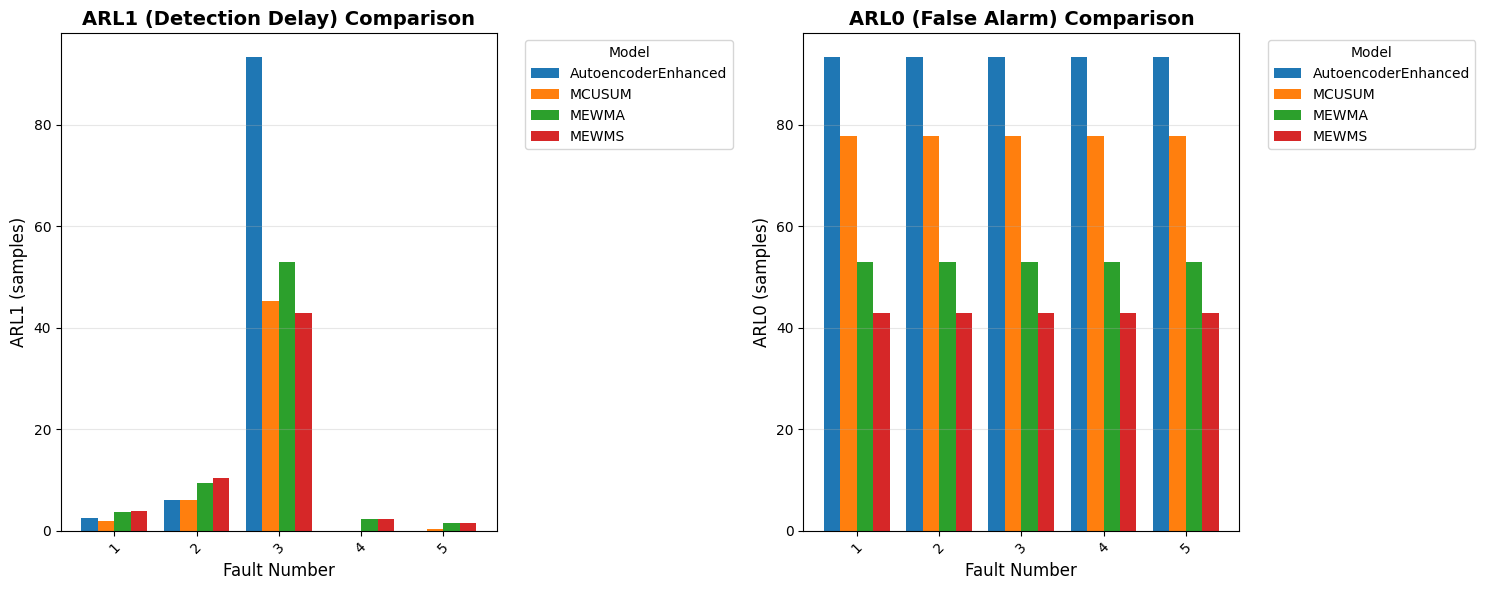


📊 ARL PLOT INTERPRETATION:
----------------------------------------
🔍 What this plot shows:
   • ARL0 (left): Time to false alarm in normal conditions (HIGHER is better)
   • ARL1 (right): Time to detect real faults (LOWER is better)
   • Box plots show distribution across all experiments

📈 Key Insights:
   • MCUSUM: ARL0=77.8, ARL1=9.2
   • AutoencoderEnhanced: ARL0=93.4, ARL1=20.4
   • MEWMA: ARL0=53.0, ARL1=10.5
   • MEWMS: ARL0=43.0, ARL1=9.5

🏆 Best Performance:
   • Lowest false alarms: AutoencoderEnhanced (ARL0=93.4)
   • Fastest detection: MCUSUM (ARL1=9.2)

2. DETECTION RATE HEATMAP


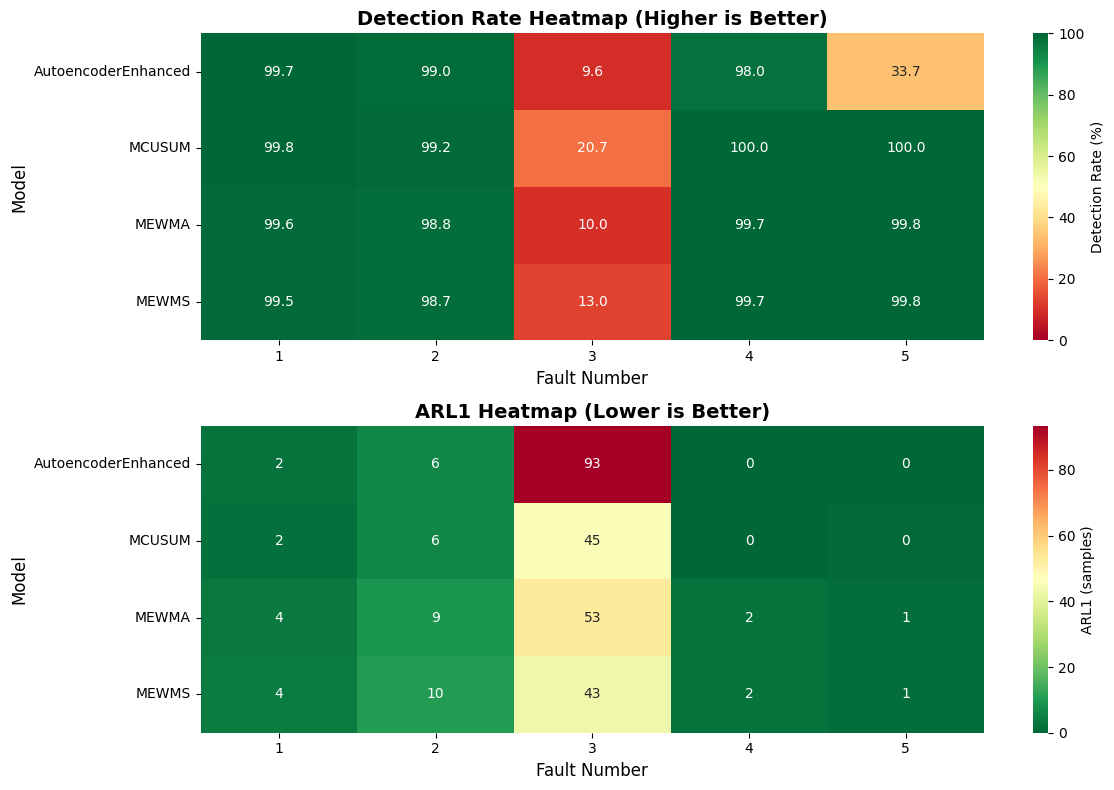


🌡️ HEATMAP INTERPRETATION:
----------------------------------------
🔍 What this plot shows:
   • Detection rate (%) for each model vs each fault type
   • Darker colors = higher detection rates (better performance)
   • Each row is a model, each column is a fault number
   Available columns in summary_df: ['model', 'faultNumber', 'conditional_ARL0', 'SDRL0', 'non_FA_fraction', 'conditional_ARL1', 'SDRL1', 'non_detection_fraction', 'avg_detection_fraction']
   Available columns in df_results: ['simulationRun', 'faultNumber', 'model', 'ARL0', 'ARL1', 'detection_fraction']
   Using fault column: faultNumber

📈 Model Rankings (by average detection rate):
   1. MCUSUM: 83.9% ± 33.4%
   2. MEWMS: 82.2% ± 35.9%
   3. MEWMA: 81.6% ± 36.7%
   4. AutoencoderEnhanced: 68.0% ± 39.8%

⚠️ Fault Difficulty (easiest to hardest):
   1. Fault 3: 13.3% detection (Hard)
   2. Fault 5: 83.3% detection (Easy)
   3. Fault 2: 99.0% detection (Easy)
   4. Fault 4: 99.4% detection (Easy)
   5. Fault 1: 99.6% d

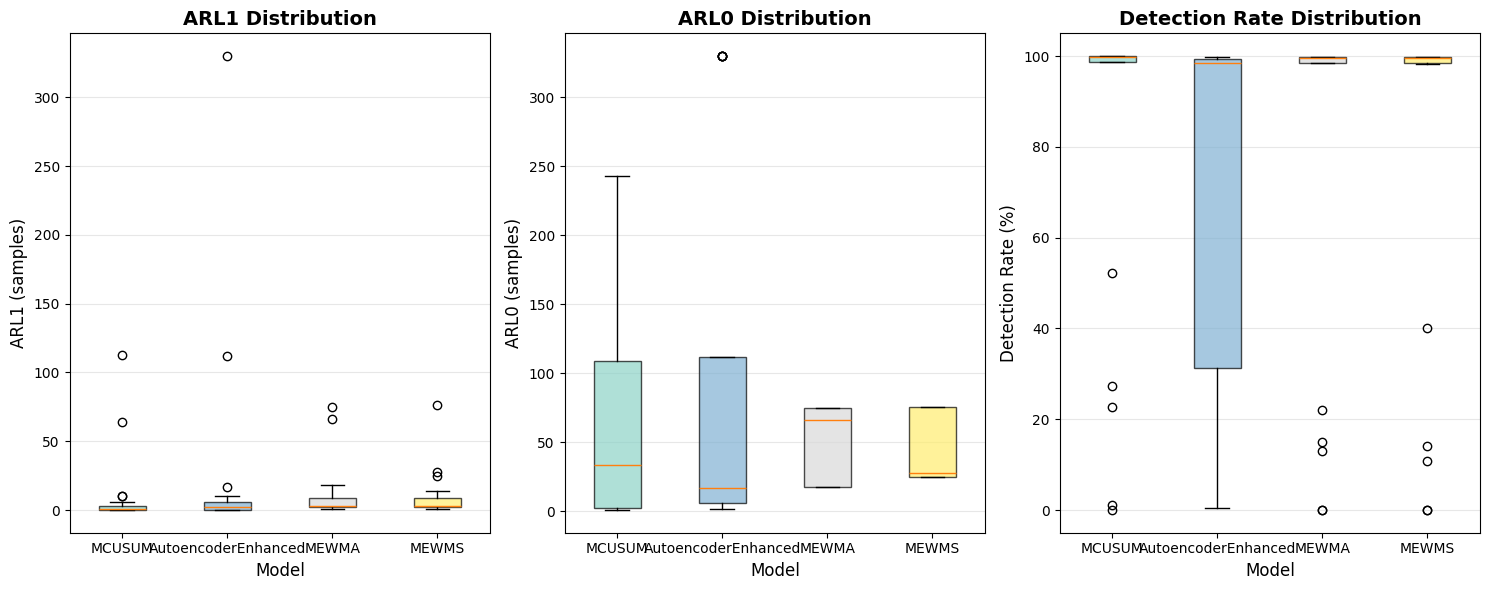


📦 BOXPLOT INTERPRETATION:
----------------------------------------
🔍 What this plot shows:
   • Distribution of performance metrics across all experiments
   • Box = 25th to 75th percentile, Line = median, Dots = outliers
   • ARL1: Lower boxes are better (faster detection)
   • ARL0: Higher boxes are better (fewer false alarms)
   • Detection Rate: Higher boxes are better

📊 Model Consistency Analysis:
   • MCUSUM: Low consistency (ARL1_CV=2.77, Det_CV=0.40)
   • AutoencoderEnhanced: Low consistency (ARL1_CV=3.35, Det_CV=0.59)
   • MEWMA: Low consistency (ARL1_CV=1.85, Det_CV=0.45)
   • MEWMS: Low consistency (ARL1_CV=1.71, Det_CV=0.44)

4. FAULT-SPECIFIC DETAILED ANALYSIS

Generating fault-specific analysis plots...

🔬 FAULT 1 ANALYSIS:
------------------------------


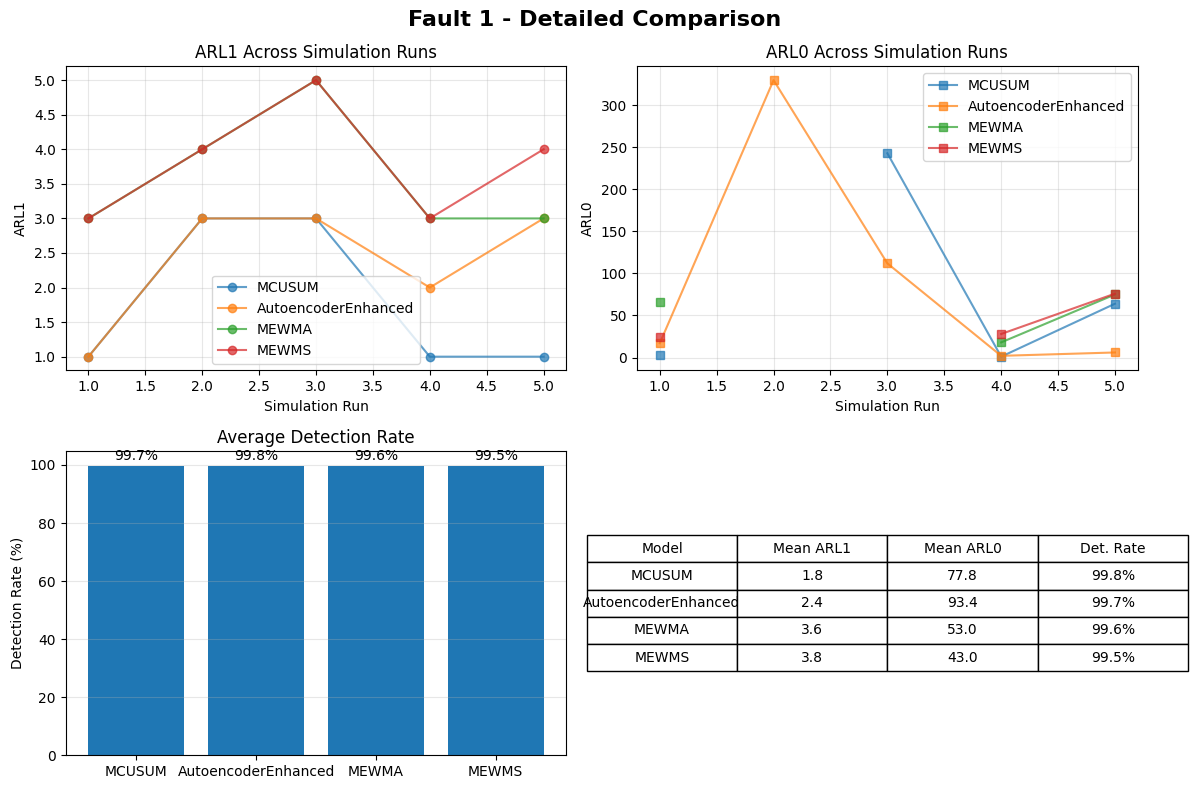

📊 Summary for Fault 1:
   🏆 Best model: MCUSUM (99.8% detection)
   ⚠️ Worst model: MEWMS (99.5% detection)
   🎯 Fault characteristics: Easy to detect (avg 99.6% detection)

🔬 FAULT 2 ANALYSIS:
------------------------------


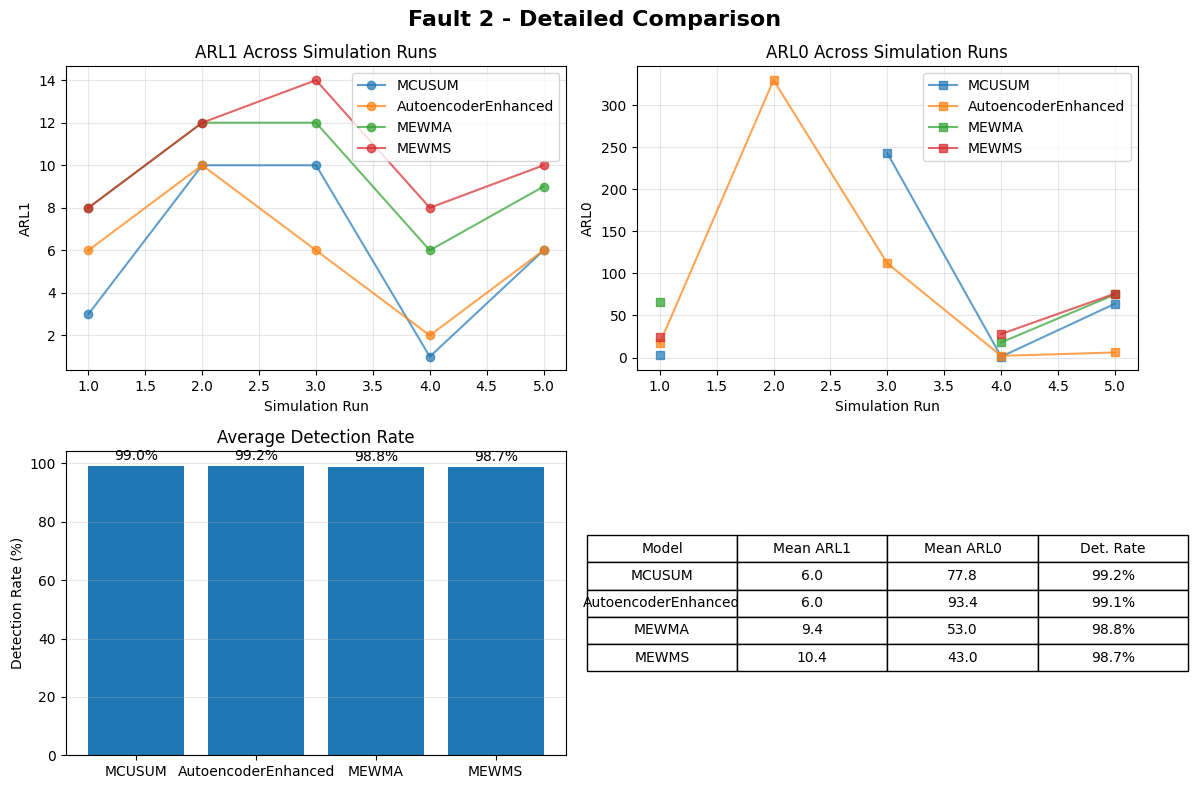

📊 Summary for Fault 2:
   🏆 Best model: MCUSUM (99.2% detection)
   ⚠️ Worst model: MEWMS (98.7% detection)
   🎯 Fault characteristics: Easy to detect (avg 99.0% detection)

🔬 FAULT 3 ANALYSIS:
------------------------------


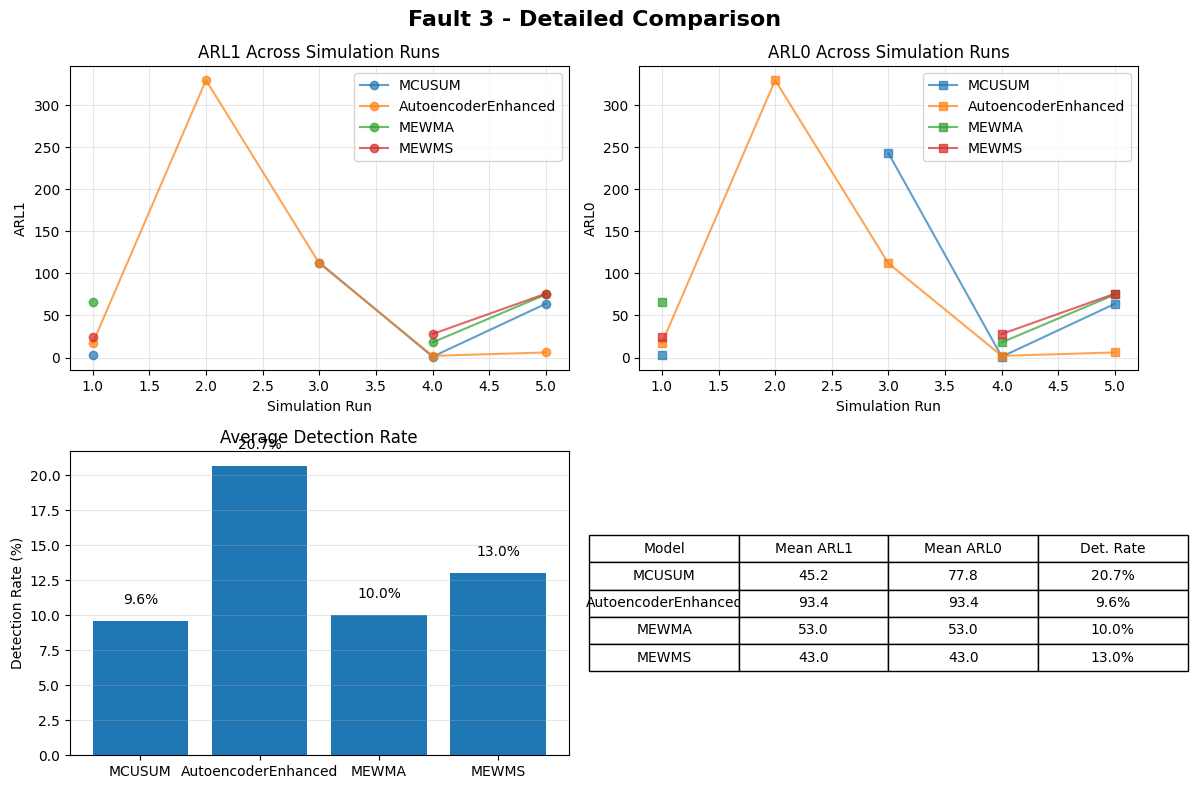

📊 Summary for Fault 3:
   🏆 Best model: MCUSUM (20.7% detection)
   ⚠️ Worst model: AutoencoderEnhanced (9.6% detection)
   🎯 Fault characteristics: Very difficult (avg 13.3% detection)

🔬 FAULT 4 ANALYSIS:
------------------------------


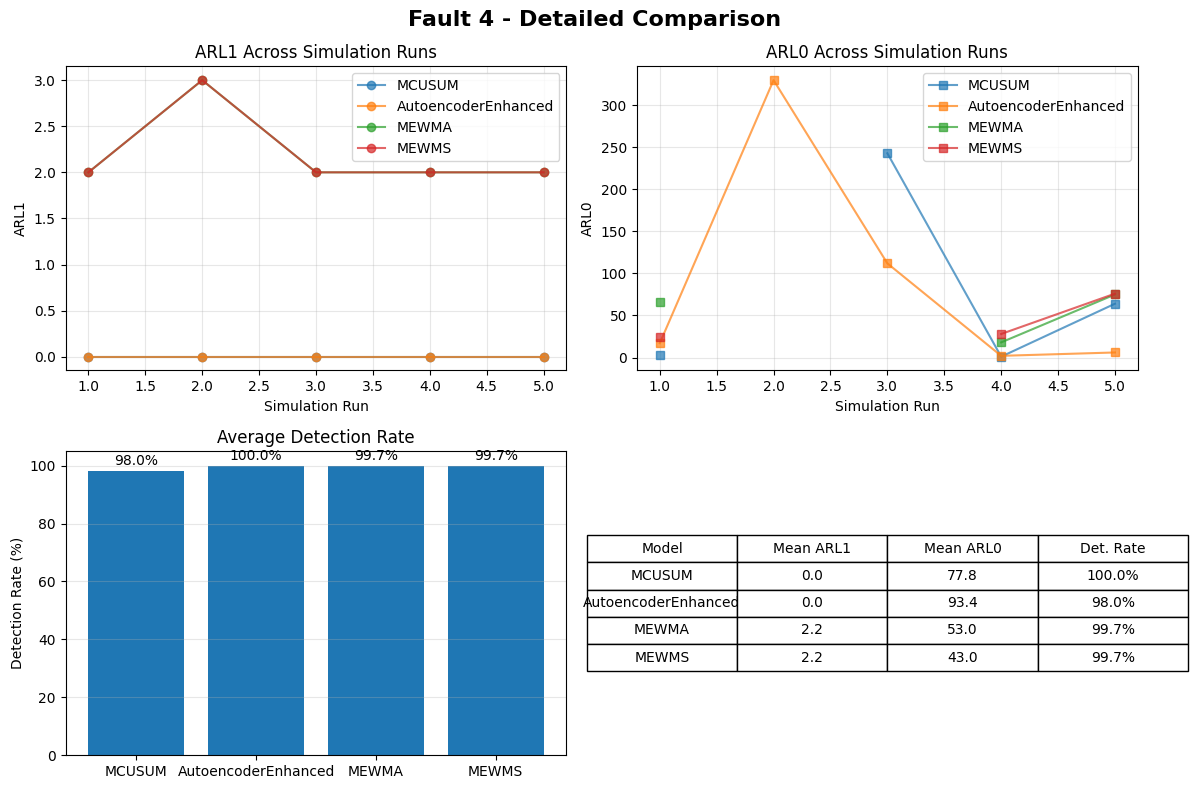

📊 Summary for Fault 4:
   🏆 Best model: MCUSUM (100.0% detection)
   ⚠️ Worst model: AutoencoderEnhanced (98.0% detection)
   🎯 Fault characteristics: Easy to detect (avg 99.4% detection)

🔬 FAULT 5 ANALYSIS:
------------------------------


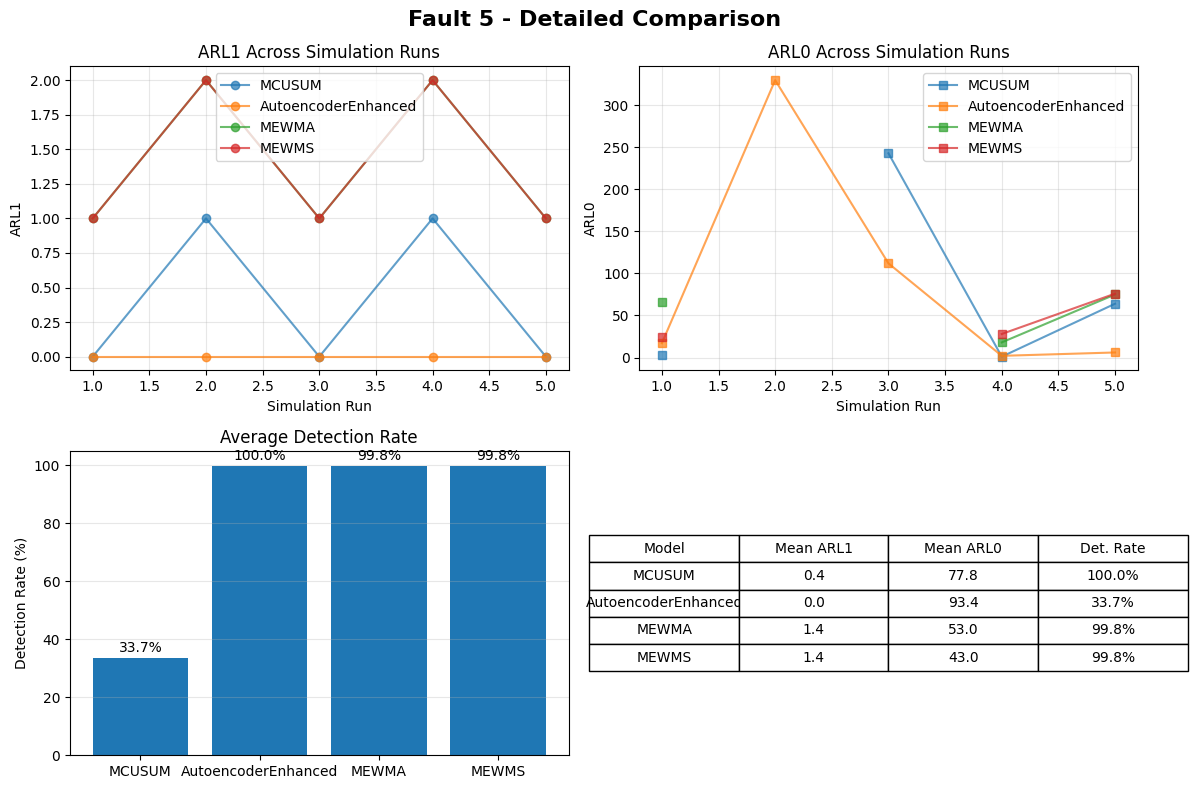

📊 Summary for Fault 5:
   🏆 Best model: MCUSUM (100.0% detection)
   ⚠️ Worst model: AutoencoderEnhanced (33.7% detection)
   🎯 Fault characteristics: Easy to detect (avg 83.3% detection)

🎯 OVERALL CONCLUSIONS & RECOMMENDATIONS
🏆 RECOMMENDED MODEL: MCUSUM
   Balanced performance across all metrics
   Detection rate: 83.9%
   Avg detection time: 9.2 samples
   False alarm interval: 77.8 samples

📊 MODEL SPECIALIZATIONS:
   ⚡ Fastest detection: MCUSUM
   🛡️ Most reliable (fewest false alarms): AutoencoderEnhanced
   🎯 Highest detection rate: MCUSUM

All visualizations and analysis completed!


In [51]:
# Generate comprehensive analysis plots with detailed summaries
print("Generating visualization plots with analysis summaries...")
import matplotlib.pyplot as plt
import numpy as np

# 1. ARL Comparison Plot
print("\n" + "="*60)
print("1. AVERAGE RUN LENGTH (ARL) COMPARISON")
print("="*60)
fig1 = analyzer.plot_arl_comparison()
plt.show()

# Summary for ARL plot
print("\n📊 ARL PLOT INTERPRETATION:")
print("-" * 40)

# Get ARL statistics for summary
arl_summary = analyzer.create_summary_statistics()
models = analyzer.models

print("🔍 What this plot shows:")
print("   • ARL0 (left): Time to false alarm in normal conditions (HIGHER is better)")
print("   • ARL1 (right): Time to detect real faults (LOWER is better)")
print("   • Box plots show distribution across all experiments")

print("\n📈 Key Insights:")
for i, model in enumerate(models):
    model_data = analyzer.df_results[analyzer.df_results['model'] == model]
    mean_arl0 = model_data['ARL0'].mean()
    mean_arl1 = model_data['ARL1'].mean()
    
    if i == 0:
        best_arl0_model = model
        best_arl0_value = mean_arl0
        best_arl1_model = model
        best_arl1_value = mean_arl1
    else:
        if mean_arl0 > best_arl0_value:
            best_arl0_model = model
            best_arl0_value = mean_arl0
        if mean_arl1 < best_arl1_value:
            best_arl1_model = model
            best_arl1_value = mean_arl1
    
    print(f"   • {model}: ARL0={mean_arl0:.1f}, ARL1={mean_arl1:.1f}")

print(f"\n🏆 Best Performance:")
print(f"   • Lowest false alarms: {best_arl0_model} (ARL0={best_arl0_value:.1f})")
print(f"   • Fastest detection: {best_arl1_model} (ARL1={best_arl1_value:.1f})")

# 2. Detection Heatmap
print("\n" + "="*60)
print("2. DETECTION RATE HEATMAP")
print("="*60)
fig2 = analyzer.plot_detection_heatmap()
plt.show()

print("\n🌡️ HEATMAP INTERPRETATION:")
print("-" * 40)
print("🔍 What this plot shows:")
print("   • Detection rate (%) for each model vs each fault type")
print("   • Darker colors = higher detection rates (better performance)")
print("   • Each row is a model, each column is a fault number")

# Get detection rate insights - check available columns first
print(f"   Available columns in summary_df: {list(analyzer.summary_df.columns)}")
print(f"   Available columns in df_results: {list(analyzer.df_results.columns)}")

# Use df_results for detailed analysis since it has the raw experimental data
detection_summary = analyzer.df_results.groupby('model')['detection_fraction'].agg(['mean', 'std']).round(3)

# Check if fault_number column exists, if not use the correct column name
fault_col = None
for col in analyzer.df_results.columns:
    if 'fault' in col.lower():
        fault_col = col
        break

if fault_col:
    print(f"   Using fault column: {fault_col}")
    fault_difficulty = analyzer.df_results.groupby(fault_col)['detection_fraction'].mean().sort_values()
else:
    print("   No fault column found - using summary_df for fault analysis")
    # Try using summary_df if it has fault information
    if 'fault_number' in analyzer.summary_df.columns:
        fault_difficulty = analyzer.summary_df.groupby('fault_number')['detection_fraction'].mean().sort_values()
    else:
        print("   Cannot perform fault difficulty analysis - no fault column available")
        fault_difficulty = None

print(f"\n📈 Model Rankings (by average detection rate):")
model_rankings = detection_summary.sort_values('mean', ascending=False)
for i, (model, stats) in enumerate(model_rankings.iterrows(), 1):
    print(f"   {i}. {model}: {stats['mean']*100:.1f}% ± {stats['std']*100:.1f}%")

if fault_difficulty is not None:
    print(f"\n⚠️ Fault Difficulty (easiest to hardest):")
    for i, (fault, rate) in enumerate(fault_difficulty.items(), 1):
        difficulty = "Easy" if rate > 0.8 else "Medium" if rate > 0.5 else "Hard"
        print(f"   {i}. Fault {fault}: {rate*100:.1f}% detection ({difficulty})")
else:
    print(f"\n⚠️ Fault Difficulty analysis not available (no fault column found)")

# 3. Performance Boxplots
print("\n" + "="*60)
print("3. PERFORMANCE DISTRIBUTION ANALYSIS")
print("="*60)
fig3 = analyzer.plot_performance_boxplots()
plt.show()

print("\n📦 BOXPLOT INTERPRETATION:")
print("-" * 40)
print("🔍 What this plot shows:")
print("   • Distribution of performance metrics across all experiments")
print("   • Box = 25th to 75th percentile, Line = median, Dots = outliers")
print("   • ARL1: Lower boxes are better (faster detection)")
print("   • ARL0: Higher boxes are better (fewer false alarms)")
print("   • Detection Rate: Higher boxes are better")

# Analyze consistency
print(f"\n📊 Model Consistency Analysis:")
for model in models:
    model_data = analyzer.df_results[analyzer.df_results['model'] == model]
    arl1_cv = model_data['ARL1'].std() / model_data['ARL1'].mean()  # Coefficient of variation
    det_cv = model_data['detection_fraction'].std() / model_data['detection_fraction'].mean()
    
    consistency = "High" if arl1_cv < 0.5 and det_cv < 0.3 else "Medium" if arl1_cv < 1.0 and det_cv < 0.5 else "Low"
    print(f"   • {model}: {consistency} consistency (ARL1_CV={arl1_cv:.2f}, Det_CV={det_cv:.2f})")

# Generate fault-specific analysis for selected faults
print("\n" + "="*60)
print("4. FAULT-SPECIFIC DETAILED ANALYSIS")
print("="*60)
print("\nGenerating fault-specific analysis plots...")

fault_insights = {}
if fault_col:
    # Get available fault numbers from the data
    available_faults = sorted(analyzer.df_results[fault_col].unique())
    faults_to_analyze = [f for f in [1, 2, 3, 4, 5] if f in available_faults]  # Use available faults
    
    for fault in faults_to_analyze:
        print(f"\n🔬 FAULT {fault} ANALYSIS:")
        print("-" * 30)
        
        fig = analyzer.plot_fault_specific_comparison(fault)
        plt.show()
        
        # Get fault-specific statistics
        fault_data = analyzer.df_results[analyzer.df_results[fault_col] == fault]
        
        if len(fault_data) > 0:
            print(f"📊 Summary for Fault {fault}:")
            
            best_model_for_fault = fault_data.groupby('model')['detection_fraction'].mean().idxmax()
            best_detection_rate = fault_data.groupby('model')['detection_fraction'].mean().max()
            
            worst_model_for_fault = fault_data.groupby('model')['detection_fraction'].mean().idxmin()
            worst_detection_rate = fault_data.groupby('model')['detection_fraction'].mean().min()
            
            print(f"   🏆 Best model: {best_model_for_fault} ({best_detection_rate*100:.1f}% detection)")
            print(f"   ⚠️ Worst model: {worst_model_for_fault} ({worst_detection_rate*100:.1f}% detection)")
            
            # Characterize the fault
            avg_detection = fault_data['detection_fraction'].mean()
            fault_char = "Easy to detect" if avg_detection > 0.8 else "Moderately difficult" if avg_detection > 0.5 else "Very difficult"
            print(f"   🎯 Fault characteristics: {fault_char} (avg {avg_detection*100:.1f}% detection)")
            
            fault_insights[fault] = {
                'best_model': best_model_for_fault,
                'best_rate': best_detection_rate,
                'avg_detection': avg_detection,
                'difficulty': fault_char
            }
        else:
            print(f"   No data available for Fault {fault}")
else:
    print("   Cannot perform fault-specific analysis - no fault column found")

# Overall conclusions
print("\n" + "="*70)
print("🎯 OVERALL CONCLUSIONS & RECOMMENDATIONS")
print("="*70)

# Find the overall best model
overall_best = analyzer.df_results.groupby('model').agg({
    'detection_fraction': 'mean',
    'ARL1': 'mean',
    'ARL0': 'mean'
}).round(3)

# Weighted score (higher detection rate + lower ARL1 + higher ARL0)
overall_best['score'] = (overall_best['detection_fraction'] * 0.5 + 
                        (1/overall_best['ARL1']) * 0.3 + 
                        (overall_best['ARL0']/overall_best['ARL0'].max()) * 0.2)

best_overall = overall_best['score'].idxmax()

print(f"🏆 RECOMMENDED MODEL: {best_overall}")
print(f"   Balanced performance across all metrics")
print(f"   Detection rate: {overall_best.loc[best_overall, 'detection_fraction']*100:.1f}%")
print(f"   Avg detection time: {overall_best.loc[best_overall, 'ARL1']:.1f} samples")
print(f"   False alarm interval: {overall_best.loc[best_overall, 'ARL0']:.1f} samples")

print(f"\n📊 MODEL SPECIALIZATIONS:")
fastest_detector = overall_best['ARL1'].idxmin()
most_reliable = overall_best['ARL0'].idxmax()
highest_detection = overall_best['detection_fraction'].idxmax()

print(f"   ⚡ Fastest detection: {fastest_detector}")
print(f"   🛡️ Most reliable (fewest false alarms): {most_reliable}")
print(f"   🎯 Highest detection rate: {highest_detection}")

print("\nAll visualizations and analysis completed!")
print("="*70)

## Step 8: Export Results and Configuration

Save experiment results and configuration for future reference.

In [40]:
# Export results and configuration
import pandas as pd
from datetime import datetime

# Save detailed results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_filename = f"experiment_results_{timestamp}.csv"
summary_filename = f"experiment_summary_{timestamp}.csv"

# Save to output directory
df_results.to_csv(f"../../../output/{results_filename}", index=False)
summary_df.to_csv(f"../../../output/{summary_filename}", index=False)

# Save current configuration
config_dict = {
    'experiment_timestamp': timestamp,
    'faults_tested': list(config.fault_numbers),
    'simulation_runs': list(config.simulation_runs),
    'detectors_used': list(detector_registry.keys()),
    'fault_injection_point': 160,
    'results_file': results_filename,
    'summary_file': summary_filename
}

# Save configuration as JSON
import json
config_filename = f"experiment_config_{timestamp}.json"
with open(f"../../../output/{config_filename}", 'w') as f:
    json.dump(config_dict, f, indent=2)

print(f"Results exported:")
print(f"  - Detailed results: {results_filename}")
print(f"  - Summary: {summary_filename}")  
print(f"  - Configuration: {config_filename}")
print(f"  - Location: output/ directory")

Results exported:
  - Detailed results: experiment_results_20250917_184744.csv
  - Summary: experiment_summary_20250917_184744.csv
  - Configuration: experiment_config_20250917_184744.json
  - Location: output/ directory


---

## Advanced Configuration Options

Modify experiment parameters and detector settings below as needed.

In [41]:
# Advanced Configuration - Modify as needed

# Custom experiment configuration
custom_config = lib.ExperimentConfig(
    simulation_runs=range(1, 11),  # Modify simulation runs range
    fault_numbers=[1, 2, 4, 5, 10, 11, 13, 14, 16, 19, 20, 21],  # Modify fault list
    apply_fault_injection_cutoff=True,  # Whether to apply cutoff
    use_minimal_registry=False,  # Use all detectors instead of minimal set
    verbose=True  # Enable verbose output
)

# Custom detector settings - uncomment and modify as needed
custom_detector_params = {
    'mcusum': {
        'k': 0.5,  # reference value
        'h': None,  # control limit (None = auto-calculate)
    },
    'autoencoder': {
        'encoding_dim': 10,
        'epochs': 100,
        'batch_size': 32,
        'threshold_percentile': 95
    },
    'autoencoder_enhanced': {
        'encoding_dim': 12,
        'epochs': 150,
        'batch_size': 16,
        'threshold_percentile': 97
    },
    'ewma': {
        'lambda_': 0.1,
        'percentile': 99.0
    }
}

print("Custom configuration defined. Use these settings by:")
print("1. Replace 'config' with 'custom_config' in model initialization")
print("2. Modify the initialize_models function to use custom_detector_params")
print("3. Re-run the experiments with new settings")
print(f"\nCustom config details:")
print(f"  - Simulation runs: {list(custom_config.simulation_runs)}")
print(f"  - Fault numbers: {custom_config.fault_numbers}")
print(f"  - Use minimal registry: {custom_config.use_minimal_registry}")

Custom configuration defined. Use these settings by:
1. Replace 'config' with 'custom_config' in model initialization
2. Modify the initialize_models function to use custom_detector_params
3. Re-run the experiments with new settings

Custom config details:
  - Simulation runs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  - Fault numbers: [1, 2, 4, 5, 10, 11, 13, 14, 16, 19, 20, 21]
  - Use minimal registry: False
